# Kaggle Competition ML FLOW

In [67]:
# importing modules to 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.stats import norm, skew
from sklearn import ensemble, metrics
from sklearn import linear_model, preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
#from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# CSVの中身を引っ張りましょう

In [68]:
import pandas as pd
train = pd.read_csv('./application_train.csv')
test = pd.read_csv('./application_test.csv')
ins = pd.read_csv('./installments_payments.csv')
cc = pd.read_csv('./credit_card_balance.csv')
pos = pd.read_csv('./POS_CASH_balance.csv')
prev = pd.read_csv('./previous_application.csv')

## Train_Test データ

In [37]:
#train_test = pd.read_csv('./train_test.csv')

# CSVをマージしていきます

# 前処理

前処理の方針：Trainデータだけで571特徴量あり、またTestデータが別のIDで存在していると考えられたため、Mergeすることにして、トレーニングとテストで同じ条件で使えるデータを増やす。とくにテストデータでも同じ条件で使いたいため。

In [69]:
# reset_indexのなかのdrop=Trueを使うことで、前の特徴のNamingを踏襲する。
train_test = train.append(test).reset_index(drop=True)
train_test.shape

(356255, 122)

In [70]:
train_test.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
train_test.shape

(356255, 122)

## 特徴量選択

In [72]:
train_test2 = train_test[['SK_ID_CURR', 'CODE_GENDER', 'NAME_CONTRACT_TYPE', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET']]
train_test2.head()

,SK_ID_CURR,CODE_GENDER,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_BIRTH,OCCUPATION_TYPE,...,NAME_INCOME_TYPE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
0,100002,M,Cash loans,202500.0,406597.5,24700.5,351000.0,-637,-9461,Laborers,...,Working,-3648.0,-2120,0.018801,2,2,0.083037,0.262949,0.139376,1.0
1,100003,F,Cash loans,270000.0,1293502.5,35698.5,1129500.0,-1188,-16765,Core staff,...,State servant,-1186.0,-291,0.003541,1,1,0.311267,0.622246,NaN,0.0
2,100004,M,Revolving loans,67500.0,135000.0,6750.0,135000.0,-225,-19046,Laborers,...,Working,-4260.0,-2531,0.010032,2,2,NaN,0.555912,0.729567,0.0
3,100006,F,Cash loans,135000.0,312682.5,29686.5,297000.0,-3039,-19005,Laborers,...,Working,-9833.0,-2437,0.008019,2,2,NaN,0.650442,NaN,0.0
4,100007,M,Cash loans,121500.0,513000.0,21865.5,513000.0,-3038,-19932,Core staff,...,Working,-4311.0,-3458,0.028663,2,2,NaN,0.322738,NaN,0.0


## Credit Card Balance CSV

In [74]:
cc2 = cc[['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL']]
cc2.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL
0,2562384,378907,-6,56.970,135000
1,2582071,363914,-1,63975.555,45000
2,1740877,371185,-7,31815.225,450000
3,1389973,337855,-4,236572.110,225000
4,1891521,126868,-1,453919.455,450000


In [78]:
cc2 = cc2.sort_values(by = 'MONTHS_BALANCE')[::-1]
cc2.head(20)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL
831309,1084313,245421,-1,0.000,0
1028949,1332696,284203,-1,0.000,135000
2282243,1074801,404129,-1,139777.830,135000
1416257,2066253,327582,-1,0.000,9000
1940896,2717141,376492,-1,0.000,13500
1940895,2291692,332956,-1,0.000,180000
2282563,2833477,446108,-1,138681.540,135000
1940881,1295539,306264,-1,0.000,45000
1940880,2693405,302527,-1,521454.645,540000
1416331,1947141,360362,-1,0.000,405000


### Drop Duplicates

In [80]:
cc3 = cc2.drop_duplicates(['SK_ID_PREV', 'SK_ID_CURR'])
cc3.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL
2248506,1794451,456250,-7,174435.885,180000
3740421,2743495,456248,-15,0.000,900000
1658055,1595171,456247,-32,0.000,180000
3123404,1079732,456246,-8,52.875,135000
1366335,2181926,456244,-34,347933.205,450000


### SK_ID_CURR で確認する

In [81]:
cc3 = cc3.sort_values(by = 'SK_ID_CURR')[::-1]
cc3.head(20)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL
2248506,1794451,456250,-7,174435.885,180000
3740421,2743495,456248,-15,0.000,900000
1658055,1595171,456247,-32,0.000,180000
3123404,1079732,456246,-8,52.875,135000
1366335,2181926,456244,-34,347933.205,450000
3285879,2640681,456242,-8,14593.185,45000
3745865,1509615,456241,-11,0.000,45000
3031036,2131120,456239,-40,273844.395,270000
1122670,2556618,456237,-4,0.000,225000
3532312,2789041,456236,-93,436.005,180000


## merging train_test2 and cc3 

In [85]:
train_test4 = pd.merge(train_test2, cc3, on='SK_ID_CURR', how = 'left')
train_test4.head(30)

,SK_ID_CURR,CODE_GENDER,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_BIRTH,OCCUPATION_TYPE,...,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL
0,100002,M,Cash loans,202500.000,406597.5,24700.5,351000.0,-637,-9461,Laborers,...,2,2,0.083037,0.262949,0.139376,1.0,NaN,NaN,NaN,NaN
1,100003,F,Cash loans,270000.000,1293502.5,35698.5,1129500.0,-1188,-16765,Core staff,...,1,1,0.311267,0.622246,NaN,0.0,NaN,NaN,NaN,NaN
2,100004,M,Revolving loans,67500.000,135000.0,6750.0,135000.0,-225,-19046,Laborers,...,2,2,NaN,0.555912,0.729567,0.0,NaN,NaN,NaN,NaN
3,100006,F,Cash loans,135000.000,312682.5,29686.5,297000.0,-3039,-19005,Laborers,...,2,2,NaN,0.650442,NaN,0.0,1489396.0,-5.0,0.0,270000.0
4,100007,M,Cash loans,121500.000,513000.0,21865.5,513000.0,-3038,-19932,Core staff,...,2,2,NaN,0.322738,NaN,0.0,NaN,NaN,NaN,NaN
5,100008,M,Cash loans,99000.000,490495.5,27517.5,454500.0,-1588,-16941,Laborers,...,2,2,NaN,0.354225,0.621226,0.0,NaN,NaN,NaN,NaN
6,100009,F,Cash loans,171000.000,1560726.0,41301.0,1395000.0,-3130,-13778,Accountants,...,2,2,0.774761,0.724000,0.492060,0.0,NaN,NaN,NaN,NaN
7,100010,M,Cash loans,360000.000,1530000.0,42075.0,1530000.0,-449,-18850,Managers,...,3,3,NaN,0.714279,0.540654,0.0,NaN,NaN,NaN,NaN
8,100011,F,Cash loans,112500.000,1019610.0,33826.5,913500.0,365243,-20099,NaN,...,2,2,0.587334,0.205747,0.751724,0.0,1843384.0,-19.0,0.0,180000.0
9,100012,M,Revolving loans,135000.000,405000.0,20250.0,405000.0,-2019,-14469,Laborers,...,2,2,NaN,0.746644,NaN,0.0,NaN,NaN,NaN,NaN


In [164]:
train_test4.shape

(357004, 47)

## 欠損をチェックしましょう

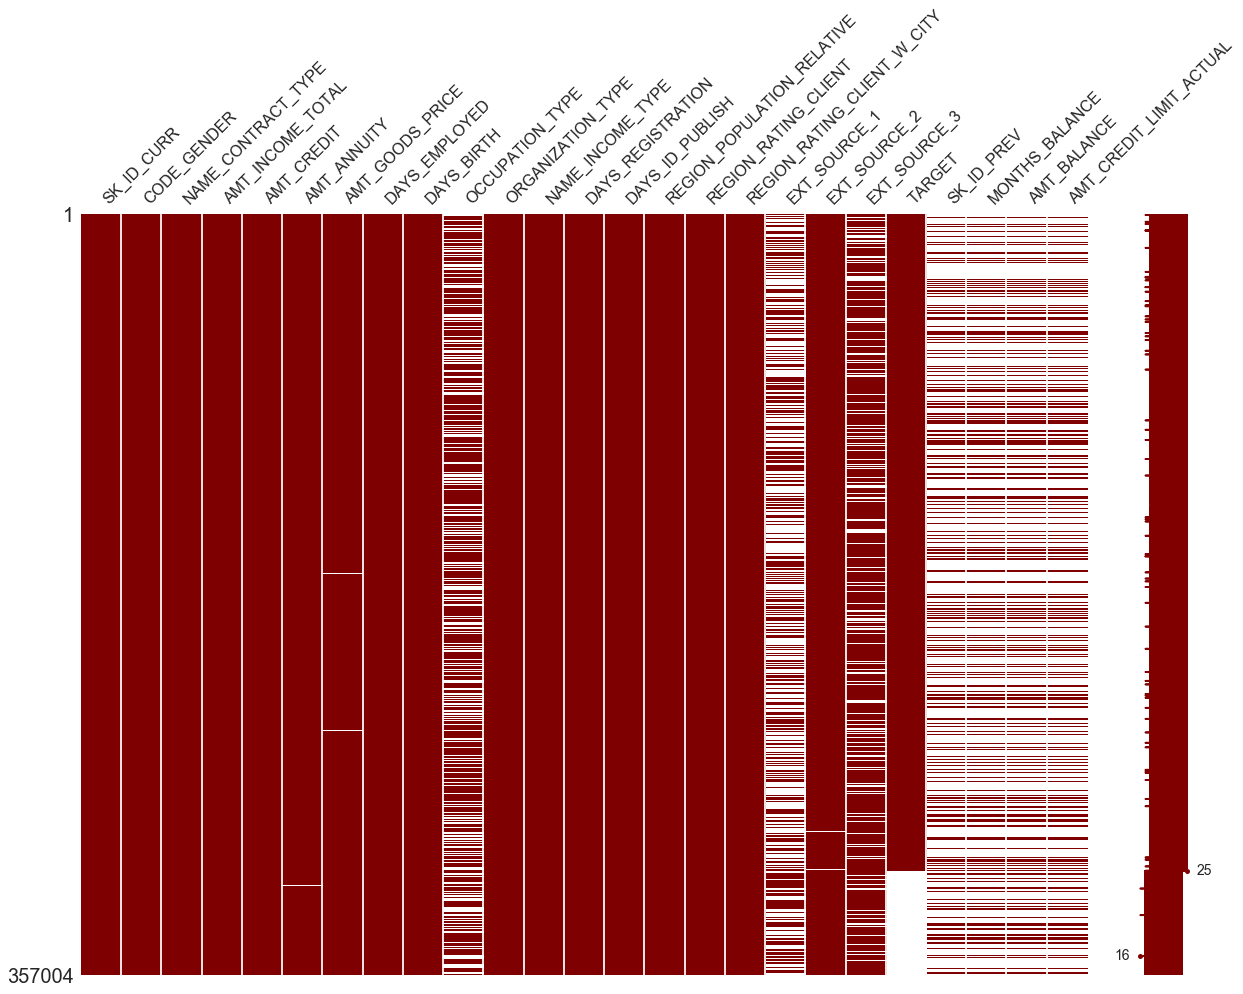

In [86]:
import missingno as msno
msno.matrix(df=train_test4, figsize=(20,14), color=(0.5,0,0))

In [87]:
print(train_test4.isnull().sum())

SK_ID_CURR                          0
CODE_GENDER                         0
NAME_CONTRACT_TYPE                  0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                        36
AMT_GOODS_PRICE                   278
DAYS_EMPLOYED                       0
DAYS_BIRTH                          0
OCCUPATION_TYPE                112219
ORGANIZATION_TYPE                   0
NAME_INCOME_TYPE                    0
DAYS_REGISTRATION                   0
DAYS_ID_PUBLISH                     0
REGION_POPULATION_RELATIVE          0
REGION_RATING_CLIENT                0
REGION_RATING_CLIENT_W_CITY         0
EXT_SOURCE_1                   194268
EXT_SOURCE_2                      668
EXT_SOURCE_3                    69726
TARGET                          48946
SK_ID_PREV                     252697
MONTHS_BALANCE                 252697
AMT_BALANCE                    252697
AMT_CREDIT_LIMIT_ACTUAL        252697
dtype: int64


# 欠損高いやつは0

In [165]:
# fillna
for c in ['OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'SK_ID_PREV', 'MONTHS_BALANCE', 'AMT_BALANCE', ]:
    train_test4[c].fillna('0', inplace=True)

## AMT Annuity, AMT_Goods_PriceのNANのところに中央値を代入する

In [170]:
for i, t in train_test4.loc[:, train_test4.columns != 'TARGET'].dtypes.iteritems():
    if t == object:
        train_test4[i].fillna(train_test4[i].mode()[0], inplace=True)
        train_test4[i] = LabelEncoder().fit_transform(train_test4[i].astype(str))
    else:
        train_test4[i].fillna(train_test4[i].median(), inplace=True)

## 再度目でもチェック

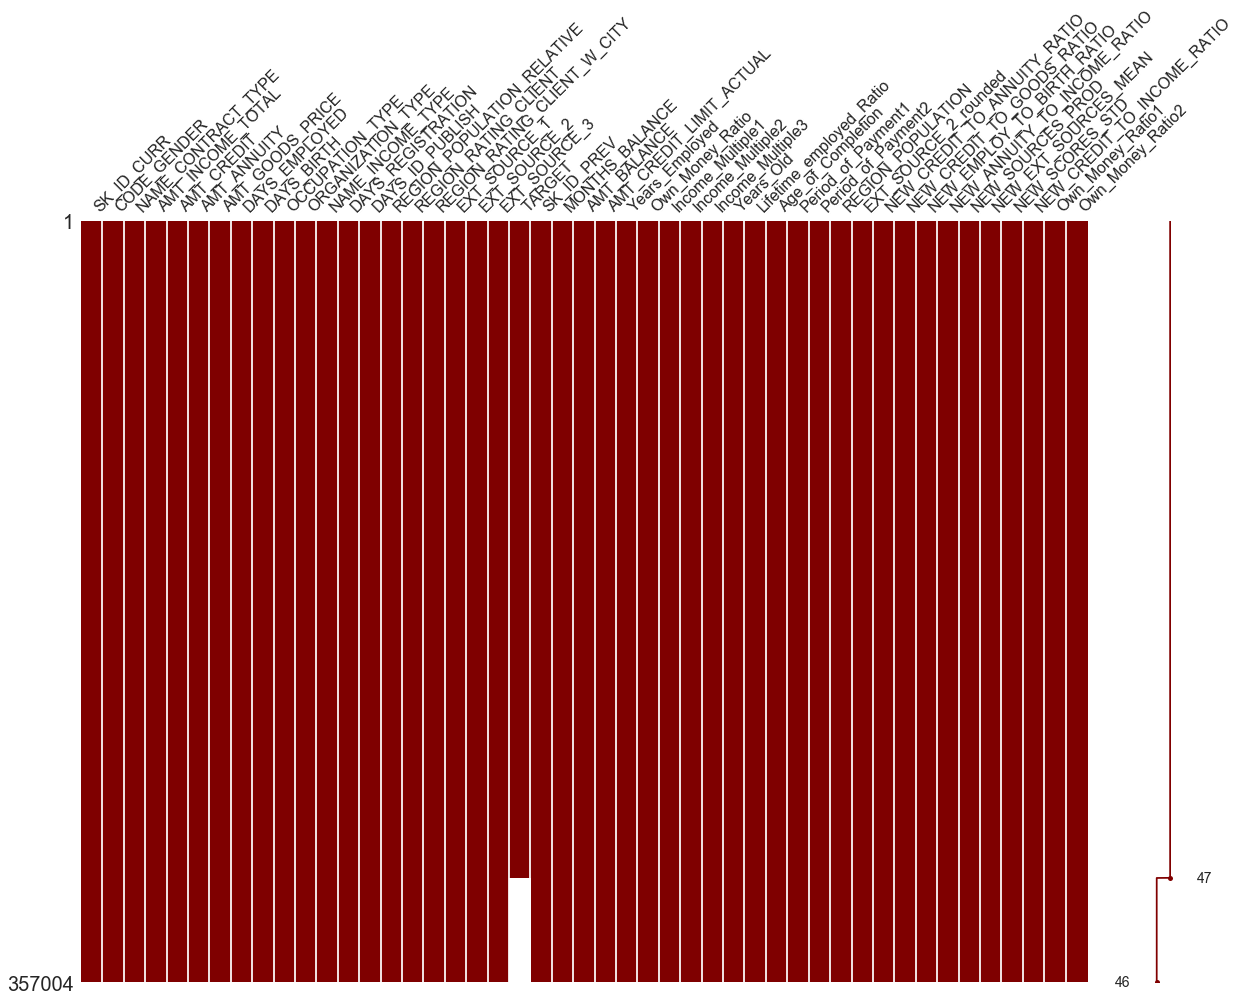

In [171]:
import missingno as msno
msno.matrix(df=train_test4, figsize=(20,14), color=(0.5,0,0))

In [172]:
train_test5 = train_test4
train_test5.head()

,SK_ID_CURR,CODE_GENDER,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_BIRTH,OCCUPATION_TYPE,...,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_EMPLOY_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_SOURCES_PROD,NEW_EXT_SOURCES_MEAN,NEW_SCORES_STD,NEW_CREDIT_TO_INCOME_RATIO,Own_Money_Ratio1,Own_Money_Ratio2
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,-637,-9461,18,...,16.461104,1.158397,0.067329,0.121977,14653140480,11135.666667,17651.968285,2.007889,0.000061,0.000185
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,-1188,-16765,13,...,36.234085,1.145199,0.070862,0.132216,0,40861.666667,46346.218447,4.790750,0.000019,0.000185
2,100004,1,1,67500.0,135000.0,6750.0,135000.0,-225,-19046,18,...,20.000000,1.000000,0.011814,0.099999,0,26510.333333,45331.346619,2.000000,0.000185,0.000185
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,-3039,-19005,18,...,10.532818,1.052803,0.159905,0.219898,0,32246.333333,55852.287691,2.316167,0.000083,0.000096
4,100007,1,0,121500.0,513000.0,21865.5,513000.0,-3038,-19932,13,...,23.461618,1.000000,0.152418,0.179961,0,13403.666667,23215.831674,4.222222,0.000049,0.000185


# 特徴量の追加を図る

## Years_Employed

In [173]:
train_test5['Years_Employed'] = round(train_test5['DAYS_EMPLOYED'] / -365)
train_test5['Years_Employed'].describe()

count    357004.000000
mean       -176.231023
std         388.331686
min       -1001.000000
25%           1.000000
50%           3.000000
75%           8.000000
max          49.000000
Name: Years_Employed, dtype: float64

## Own_Money_Ratio

In [174]:
train_test5['Own_Money_Ratio1'] = train_test5['AMT_BALANCE']  / train_test5['AMT_CREDIT']
train_test5['Own_Money_Ratio1'].describe()

count    357004.000000
mean          0.007646
std           0.032334
min           0.000000
25%           0.000034
50%           0.000057
75%           0.000116
max           0.954111
Name: Own_Money_Ratio1, dtype: float64

In [175]:
train_test5['Own_Money_Ratio2'] = train_test5['AMT_BALANCE']  / train_test5['AMT_CREDIT_LIMIT_ACTUAL']
train_test5['Own_Money_Ratio2'].describe()

count    3.570040e+05
mean              inf
std               NaN
min      0.000000e+00
25%      1.851852e-04
50%      1.851852e-04
75%      1.851852e-04
max               inf
Name: Own_Money_Ratio2, dtype: float64

## Income_Multiple

In [176]:
train_test5['Income_Multiple1'] = train_test5['AMT_CREDIT']  / train_test5['AMT_INCOME_TOTAL']
train_test5['Income_Multiple1'].describe()

count    357004.000000
mean          3.848815
std           2.634474
min           0.004808
25%           2.000000
50%           3.158857
75%           5.000000
max          84.736842
Name: Income_Multiple1, dtype: float64

In [177]:
train_test5['Income_Multiple2'] = train_test5['AMT_CREDIT'] /  (train_test5['AMT_INCOME_TOTAL'] + train_test5['AMT_ANNUITY'] + train_test5['AMT_GOODS_PRICE'] ) 
train_test5['Income_Multiple2'].describe()

count    357004.000000
mean          0.772683
std           0.161279
min           0.004788
25%           0.669505
50%           0.782918
75%           0.885952
max           1.935484
Name: Income_Multiple2, dtype: float64

In [178]:
train_test5['Income_Multiple3'] = train_test5['AMT_CREDIT'] /  (train_test5['AMT_INCOME_TOTAL'] + train_test5['AMT_ANNUITY'] + train_test5['AMT_GOODS_PRICE'] )
train_test5['Income_Multiple3'].describe()

count    357004.000000
mean          0.772683
std           0.161279
min           0.004788
25%           0.669505
50%           0.782918
75%           0.885952
max           1.935484
Name: Income_Multiple3, dtype: float64

## Organization_Type = Self_emp

In [179]:
train_test5['ORGANIZATION_TYPE'] = train_test5['ORGANIZATION_TYPE']
train_test5['ORGANIZATION_TYPE'].describe()

count    357004.000000
mean         37.533649
std          14.219013
min           0.000000
25%          27.000000
50%          42.000000
75%          47.000000
max          57.000000
Name: ORGANIZATION_TYPE, dtype: float64

## Years_Old

In [180]:
train_test5['Years_Old'] = round(train_test5['DAYS_BIRTH'] / -365)
train_test5['Years_Old'].describe()

count    357004.000000
mean         43.950538
std          11.945880
min          20.000000
25%          34.000000
50%          43.000000
75%          54.000000
max          69.000000
Name: Years_Old, dtype: float64

## Lifetime_employed_Ratio

In [181]:
train_test5['Lifetime_employed_Ratio'] = train_test5['Years_Employed'] / train_test5['Years_Old'] 
train_test5['Lifetime_employed_Ratio'].describe()

count    357004.000000
mean         -2.943620
std           6.648429
min         -47.666667
25%           0.023810
50%           0.089286
75%           0.192308
max           0.731343
Name: Lifetime_employed_Ratio, dtype: float64

## Age_of_Completion(25% of income is credit payable)

In [182]:
train_test5['Age_of_Completion'] = round(train_test5['Years_Old'] + (train_test5['AMT_CREDIT'] / (train_test5['AMT_INCOME_TOTAL'] /4)))
train_test5['Age_of_Completion'].describe()

count    357004.000000
mean         59.346839
std          16.841374
min          22.000000
25%          46.000000
50%          58.000000
75%          71.000000
max         398.000000
Name: Age_of_Completion, dtype: float64

## Period_of_Payment

In [183]:
train_test5['Period_of_Payment1'] = (round(train_test5['Age_of_Completion'] - train_test5['Years_Old']))**2
train_test5['Period_of_Payment1'].describe()

count    357004.000000
mean        348.166931
std         607.896166
min           0.000000
25%          64.000000
50%         169.000000
75%         400.000000
max      114921.000000
Name: Period_of_Payment1, dtype: float64

In [184]:
train_test5['Period_of_Payment2'] = (train_test5['MONTHS_BALANCE'])**2
train_test5['Period_of_Payment2'].describe()

count    357004.000000
mean       7058.316358
std        3579.124735
min           0.000000
25%        4356.000000
50%        9216.000000
75%        9216.000000
max        9216.000000
Name: Period_of_Payment2, dtype: float64

## Region_Populationデータをバンドのデータに変換

In [185]:
r = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.1]
g = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_test5['REGION_POPULATION'] = pd.cut(train_test5['REGION_POPULATION_RELATIVE'], bins=r, labels=g)
train_test5['REGION_POPULATION'].describe()

count     357004
unique         9
top            3
freq       68622
Name: REGION_POPULATION, dtype: int64

## EXT_SOURCE_2

In [186]:
train_test5['EXT_SOURCE_2_rounded'] = round(train_test5['EXT_SOURCE_2'] * 100)
train_test5['EXT_SOURCE_2_rounded'].describe()

count    3.570040e+05
mean     7.410183e+06
std      3.175975e+06
min      0.000000e+00
25%      5.122000e+06
50%      8.040500e+06
75%      9.922625e+06
max      1.271570e+07
Name: EXT_SOURCE_2_rounded, dtype: float64

In [187]:
train_test5['NEW_CREDIT_TO_ANNUITY_RATIO'] = train_test5['AMT_CREDIT'] / train_test5['AMT_ANNUITY']
train_test5['NEW_CREDIT_TO_GOODS_RATIO'] = train_test5['AMT_CREDIT'] / train_test5['AMT_GOODS_PRICE']
#train_test['NEW_INC_PER_CHLD'] = train_test['AMT_INCOME_TOTAL'] / (1 + train_test['CNT_CHILDREN'])
#train_test5['NEW_INC_BY_ORG'] = train_test5['ORGANIZATION_TYPE'].map(inc_by_org)
train_test5['NEW_EMPLOY_TO_BIRTH_RATIO'] = train_test5['DAYS_EMPLOYED'] / train_test5['DAYS_BIRTH']
train_test5['NEW_ANNUITY_TO_INCOME_RATIO'] = train_test5['AMT_ANNUITY'] / (1 + train_test5['AMT_INCOME_TOTAL'])
train_test5['NEW_SOURCES_PROD'] = train_test5['EXT_SOURCE_1'] * train_test5['EXT_SOURCE_2'] * train_test5['EXT_SOURCE_3']
train_test5['NEW_EXT_SOURCES_MEAN'] = train_test5[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
train_test5['NEW_SCORES_STD'] = train_test5[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
train_test5['NEW_SCORES_STD'] = train_test5['NEW_SCORES_STD'].fillna(train_test5['NEW_SCORES_STD'].mean())
#train_test['NEW_CAR_TO_BIRTH_RATIO'] = train_test['OWN_CAR_AGE'] / train_test5['DAYS_BIRTH']
#train_test['NEW_CAR_TO_EMPLOY_RATIO'] = train_test['OWN_CAR_AGE'] / train_test['DAYS_EMPLOYED']
#train_test['NEW_PHONE_TO_BIRTH_RATIO'] = train_test['DAYS_LAST_PHONE_CHANGE'] / train_test['DAYS_BIRTH']
#train_test['NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER'] = train_test['DAYS_LAST_PHONE_CHANGE'] / train_test['DAYS_EMPLOYED']
train_test5['NEW_CREDIT_TO_INCOME_RATIO'] = train_test5['AMT_CREDIT'] / train_test5['AMT_INCOME_TOTAL']

In [188]:
train_test5.head()

,SK_ID_CURR,CODE_GENDER,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_BIRTH,OCCUPATION_TYPE,...,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_EMPLOY_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_SOURCES_PROD,NEW_EXT_SOURCES_MEAN,NEW_SCORES_STD,NEW_CREDIT_TO_INCOME_RATIO,Own_Money_Ratio1,Own_Money_Ratio2
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,-637,-9461,18,...,16.461104,1.158397,0.067329,0.121977,14653140480,11135.666667,17651.968285,2.007889,0.000061,0.000185
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,-1188,-16765,13,...,36.234085,1.145199,0.070862,0.132216,0,40861.666667,46346.218447,4.790750,0.000019,0.000185
2,100004,1,1,67500.0,135000.0,6750.0,135000.0,-225,-19046,18,...,20.000000,1.000000,0.011814,0.099999,0,26510.333333,45331.346619,2.000000,0.000185,0.000185
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,-3039,-19005,18,...,10.532818,1.052803,0.159905,0.219898,0,32246.333333,55852.287691,2.316167,0.000083,0.000096
4,100007,1,0,121500.0,513000.0,21865.5,513000.0,-3038,-19932,13,...,23.461618,1.000000,0.152418,0.179961,0,13403.666667,23215.831674,4.222222,0.000049,0.000185


# 特徴量Check

## 数値データをカテゴリカルデータに変更する

In [189]:
 # to categorical feature
cols = ['CODE_GENDER', 'NAME_CONTRACT_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REGION_POPULATION', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY' ]
for c in cols:
    train_test5[c] = train_test5[c].astype(str)

## 再度欠損値のチェックをしましょう

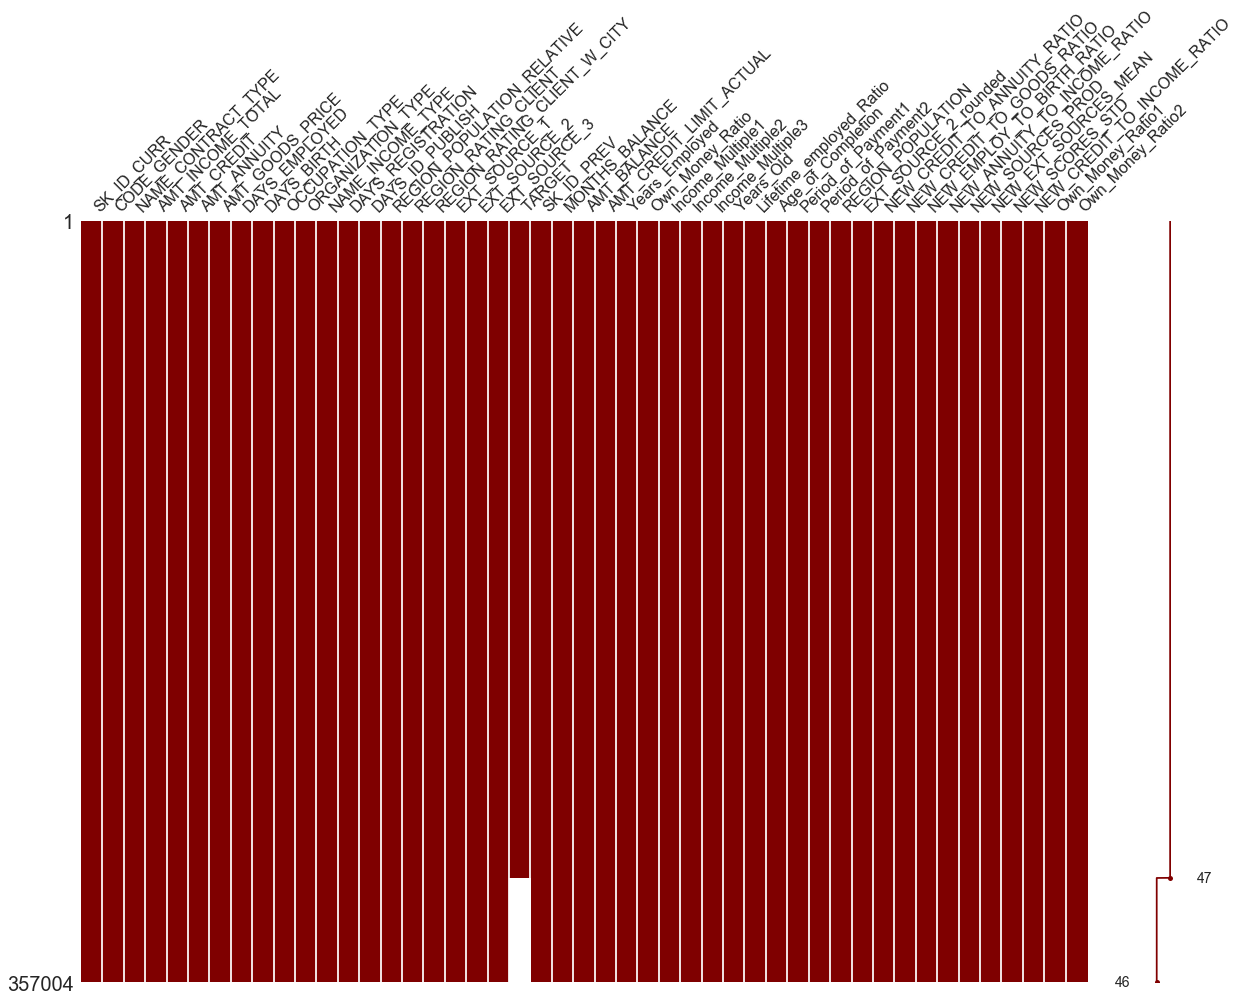

In [190]:
import missingno as msno
msno.matrix(df=train_test5, figsize=(20,14), color=(0.5,0,0))

#  エンコーディング：ラベルとワンホット

## ラベルエンコーダー and ワンホットエンコーダー

In [192]:
#　カラムの中を見て２変数だったらラベルエンコーダーにして&それ以外はワンホットエンコーダーする構文

from sklearn import preprocessing

train_test_encoded = train_test5
le = preprocessing.LabelEncoder()
for col in train_test5:
   if train_test5[col].dtype == "object":
       if len(list(train_test5[col].unique())) <= 2:
           le.fit(train_test5[col])
           
           train_test_encoded[col] = le.transform(train_test5[col])
        
train_test_encoded = pd.get_dummies(train_test_encoded)
#return df_train_
train_test_encoded.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,REGION_RATING_CLIENT_W_CITY_3,REGION_POPULATION_0,REGION_POPULATION_1,REGION_POPULATION_2,REGION_POPULATION_3,REGION_POPULATION_4,REGION_POPULATION_5,REGION_POPULATION_6,REGION_POPULATION_7,REGION_POPULATION_9
0,100002,0,202500.0,406597.5,24700.5,351000.0,-637,-9461,-3648.0,-2120,...,0,0,0,0,1,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,-1188,-16765,-1186.0,-291,...,0,1,0,0,0,0,0,0,0,0
2,100004,1,67500.0,135000.0,6750.0,135000.0,-225,-19046,-4260.0,-2531,...,0,0,0,1,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,-3039,-19005,-9833.0,-2437,...,0,0,1,0,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,-3038,-19932,-4311.0,-3458,...,0,0,0,0,0,0,1,0,0,0
5,100008,0,99000.0,490495.5,27517.5,454500.0,-1588,-16941,-4970.0,-477,...,0,0,0,0,0,0,0,0,1,0
6,100009,0,171000.0,1560726.0,41301.0,1395000.0,-3130,-13778,-1213.0,-619,...,0,0,0,0,0,0,0,0,1,0
7,100010,0,360000.0,1530000.0,42075.0,1530000.0,-449,-18850,-4597.0,-2379,...,1,1,0,0,0,0,0,0,0,0
8,100011,0,112500.0,1019610.0,33826.5,913500.0,365243,-20099,-7427.0,-3514,...,0,0,0,0,1,0,0,0,0,0
9,100012,1,135000.0,405000.0,20250.0,405000.0,-2019,-14469,-14437.0,-3992,...,0,0,0,0,1,0,0,0,0,0


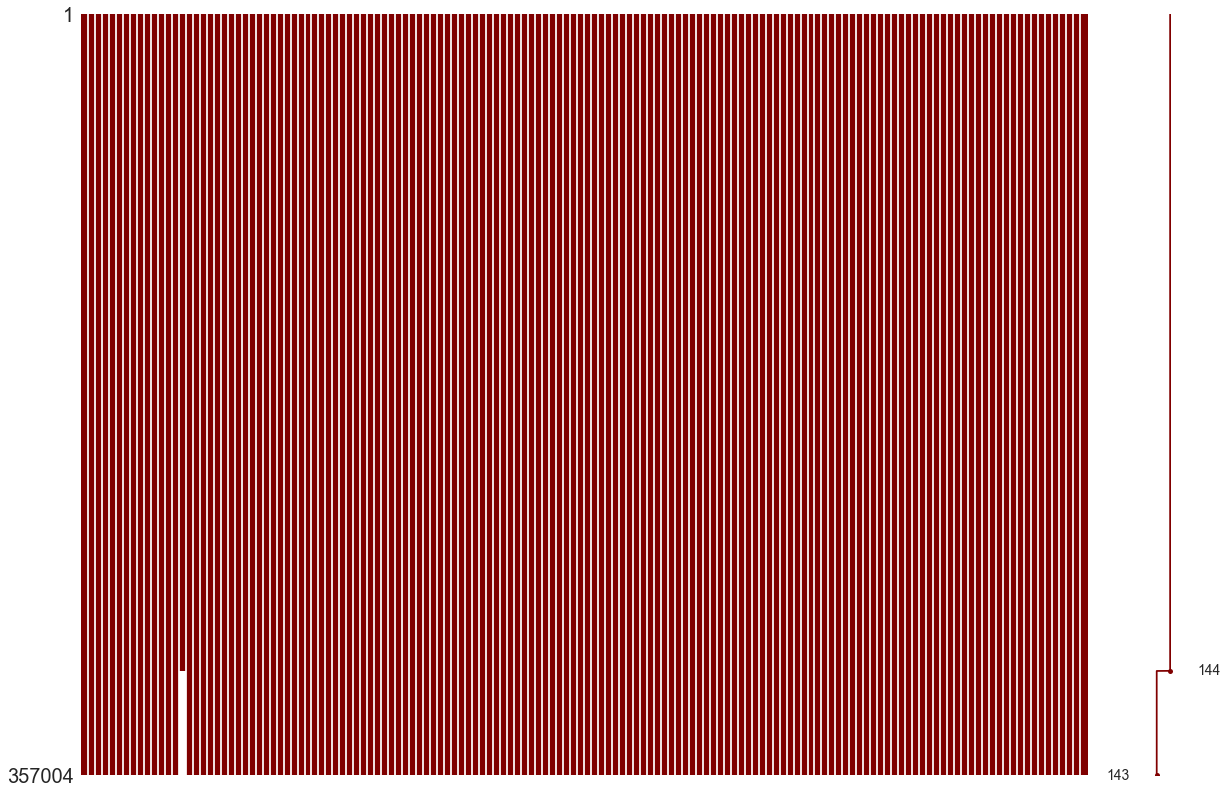

In [193]:
import missingno as msno
msno.matrix(df=train_test_encoded, figsize=(20,14), color=(0.5,0,0))

## notnullになっている部分をtrainとする

In [194]:
train = train_test_encoded[train_test_encoded['TARGET'].notnull()]
train.shape

(308058, 144)

## isnull になっている部分をtest として、そこから目的部分を取り除く

In [196]:
test = train_test_encoded[train_test_encoded['TARGET'].isnull()].drop('TARGET', axis=1)
test.shape

(48946, 143)

# 外れ値の研究（trainデータのみ）

## 外れ値を消します

### Years_Employed

In [198]:
train['Years_Employed'].describe()

count    308058.000000
mean       -174.852804
std         387.152413
min       -1001.000000
25%           1.000000
50%           3.000000
75%           8.000000
max          49.000000
Name: Years_Employed, dtype: float64

In [199]:
train = train[train['Years_Employed'] > -100]
train['Years_Employed'].describe()

count    252598.000000
mean          6.534711
std           6.412494
min           0.000000
25%           2.000000
50%           5.000000
75%           9.000000
max          49.000000
Name: Years_Employed, dtype: float64

### Own_Money_Ratio

In [200]:
train['Own_Money_Ratio1'].describe()

count    252598.000000
mean          0.007764
std           0.031837
min           0.000000
25%           0.000032
50%           0.000056
75%           0.000116
max           0.954111
Name: Own_Money_Ratio1, dtype: float64

In [201]:
train['Own_Money_Ratio2'].describe()

count    2.525980e+05
mean              inf
std               NaN
min      0.000000e+00
25%      1.851852e-04
50%      1.851852e-04
75%      1.851852e-04
max               inf
Name: Own_Money_Ratio2, dtype: float64

# 学習の準備

## trainデータを　XとyとX_testに分けます

In [202]:
X = train.drop(['TARGET'], axis=1)
y = train['TARGET']
X_test = test

print(X.shape, y.shape, X_test.shape)

(252598, 143) (252598,) (48946, 143)


#  学習

## Light GBM

In [203]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        nthread=4,
        #is_unbalance=True,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.04,
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
        #scale_pos_weight=11
    )




clf.fit(X,y)





LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
        min_child_samples=20, min_child_weight=40,
        min_split_gain=0.0222415, n_estimators=10000, n_jobs=-1, nthread=4,
        num_leaves=32, objective=None, random_state=None, reg_alpha=0.04,
        reg_lambda=0.073, silent=-1, subsample=0.8715623,
        subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [204]:
clf_pred = clf.predict_proba(X_test)[:, 1]
clf_pred

array([0.01121719, 0.06417122, 0.01145523, ..., 0.02032433, 0.03126969,
       0.35420636])

In [205]:
submission_clf = pd.DataFrame({
        "SK_ID_CURR": X_test["SK_ID_CURR"],
        "TARGET": clf_pred
    })
submission_clf

,SK_ID_CURR,TARGET
308058,100001,0.011217
308059,100005,0.064171
308060,100013,0.011455
308061,100028,0.020953
308062,100038,0.076641
308063,100042,0.022957
308064,100057,0.010893
308065,100065,0.021580
308066,100066,0.005184
308067,100067,0.038986


In [209]:
submission_clf = submission_clf.sort_values(by = 'SK_ID_CURR')[::1]
submission_clf.head(100)

,SK_ID_CURR,TARGET
308058,100001,0.011217
308059,100005,0.064171
308060,100013,0.011455
308061,100028,0.020953
308062,100038,0.076641
308063,100042,0.022957
308064,100057,0.010893
308065,100065,0.021580
308066,100066,0.005184
308067,100067,0.038986


In [211]:
submission_clf = submission_clf.drop_duplicates(['SK_ID_CURR'])
submission_clf.head()

,SK_ID_CURR,TARGET
308058,100001,0.011217
308059,100005,0.064171
308060,100013,0.011455
308061,100028,0.020953
308062,100038,0.076641


In [212]:
#CSVへ吐き出す
submission_clf.to_csv('submission_clf.csv', index=False)

### local 評価

In [213]:
from sklearn.model_selection import train_test_split
X_train, X_train_test, y_train, y_train_test = train_test_split(X, y, test_size=0.3)

In [214]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        nthread=4,
        #is_unbalance=True,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.04,
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
        #scale_pos_weight=11
    )




clf.fit(X_train,y_train)







LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
        min_child_samples=20, min_child_weight=40,
        min_split_gain=0.0222415, n_estimators=10000, n_jobs=-1, nthread=4,
        num_leaves=32, objective=None, random_state=None, reg_alpha=0.04,
        reg_lambda=0.073, silent=-1, subsample=0.8715623,
        subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [215]:
#ローカルでのスコア
clf.score(X_train_test, y_train_test)

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.911388229084191

In [216]:
clf_pred_loc = clf.predict_proba(X_train_test)[:, 1]
clf_pred_loc

array([0.075808  , 0.02989723, 0.23797197, ..., 0.01369184, 0.07700036,
       0.03938105])

In [217]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_test, clf_pred_loc)

0.7402294807995853

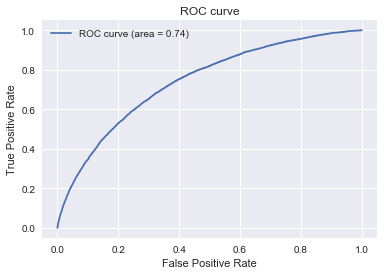

In [218]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_train_test, clf_pred_loc)

# ついでにAUCも
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label ='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)